In [293]:
"""
This notebook evaluates the performance of different filters for
image segmentation of the spectrogram produced by the PyBirales
Channeliser. 

Notebook reproduces the figures used in the 
streak detection paper.

"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

In [294]:
from skimage import data
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_local
from skimage.filters import median

In [295]:
ROOT = "/home/denis/.birales/visualisation/fits"
OUT_DIR = "/home/denis/.birales/visualisation/analysis"
FITS_FILE = "norad_1328/norad_1328_raw_1.fits"
SAVE_FIGURES = False
TX = 410.085e6
BNDW = 0.078125e6
START_FREQ = 410.0425e6
END_FREQ = 410.0425e6 + BNDW
N_CHANS = 8192
SAMPLING_RATE = 78125
TD = 1./ SAMPLING_RATE
OBS_NAME = "NORAD_1328"

In [296]:
fits_file = fits.open(os.path.join(ROOT, FITS_FILE))

In [297]:
image_data = fits_file[0].data[0]

print ('Data shape: {} channels and {} samples'.format(image_data.shape[0], image_data.shape[1]))

def save_figure(filename):
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUT_DIR, OBS_NAME, filename, '.pdf'))

Data shape: 8192 channels and 1600 samples


Image Data reduced to: 300 channels and 100 samples


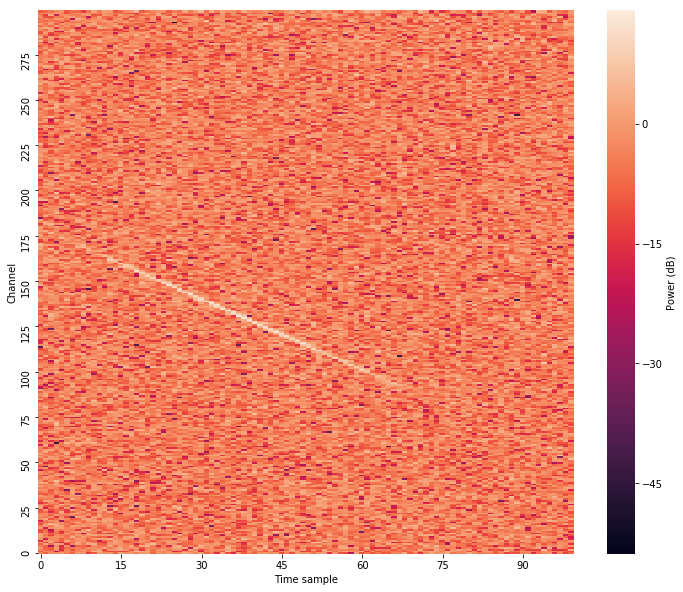

In [298]:
time_samples = np.arange(0, image_data.shape[1])
channel_samples = np.arange(0, N_CHANS)

time = time_samples * TD
channels = np.linspace(start=START_FREQ, stop=END_FREQ, num=N_CHANS)

# Choose what subset of the image data to show (c0, cn, t0, tn)
SUBSET = (4100, 4400, 800, 900)
subset_data = image_data[SUBSET[0]:SUBSET[1], SUBSET[2]:SUBSET[3]]
print ('Image Data reduced to: {} channels and {} samples'.format(subset_data.shape[0], subset_data.shape[1]))

ax0 = sns.heatmap(subset_data, cbar_kws={'label': 'Power (dB)'}, 
#                   square=True, 
                  xticklabels=15, 
                  yticklabels=25)
ax0.invert_yaxis()
ax0.set(xlabel='Time sample', ylabel='Channel')   

save_figure('before_filter')

Noise: -4.80 dB, Thres: 6.34 dB (~SNR: -1.34 dB)


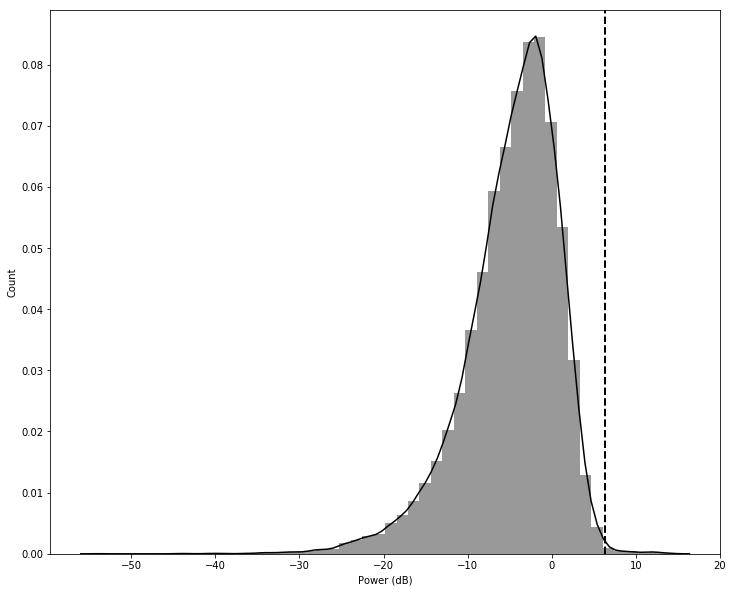

In [299]:
# Background noise filter: Show noise distribution (histogram) before and after filter is applied
def threshold(data):
    channel_noise = np.mean(data, axis=1)
    std = np.std(data, axis=1)
    
    threshold = 2 * std + channel_noise    

    return channel_noise, threshold

channel_noise, threshold = threshold(subset_data)
print('Noise: {:0.2f} dB, Thres: {:0.2f} dB (~SNR: {:0.2f} dB)'.format(np.mean(channel_noise), np.mean(threshold), np.mean(threshold/channel_noise)))

ax1 = sns.distplot(subset_data.flatten(), color='black')
ax1.set(xlabel='Power (dB)', ylabel='Count')   
ax1.axvline(x=np.mean(threshold), ymin=0, ymax=1, linewidth=2,linestyle='dashed', color='black')

save_figure('noise_distribution')

In [300]:
def visualise_filter(data, mask, threshold, filename):
    ax = sns.heatmap(data, cbar_kws={'label': 'Power (dB)'},                   
                  xticklabels=25, 
                  yticklabels=25,
                  mask=mask
                 )
    ax.invert_yaxis()
    ax.set(xlabel='Time sample', ylabel='Channel')   
    
    print('Noise: {:0.2f} dB, Thres: {:0.2f} dB (~SNR: {:0.2f} dB)'.format(np.mean(data), np.mean(threshold), np.mean(threshold/np.mean(data))))

    save_figure(filename)
    

/home/denis/.venv/birales/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


Noise: -4.80 dB, Thres: 6.34 dB (~SNR: -1.32 dB)


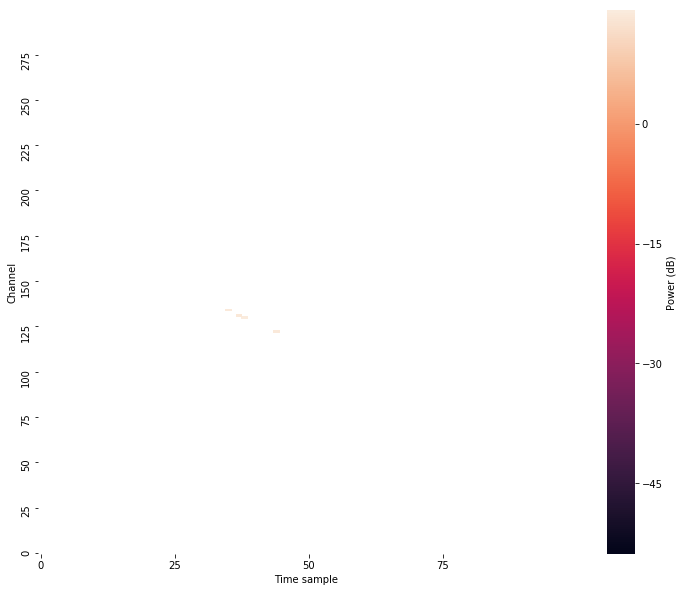

In [306]:
"Test median filter"
bf_filter_mask = np.where(subset_data<np.expand_dims(13.28, axis=1), subset_data, 0)
visualise_filter(subset_data, bf_filter_mask, threshold, 'after_bf_filter')

Noise: -4.82 dB, Thres: -6.65 dB (~SNR: 1.38 dB)


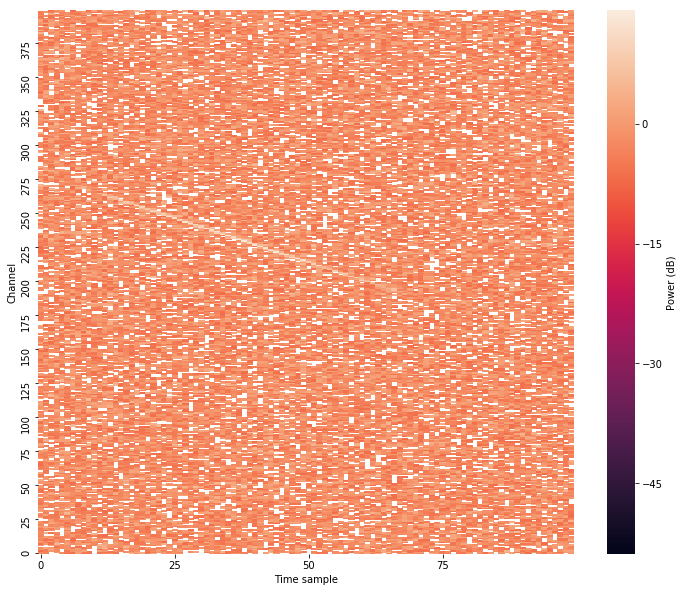

In [231]:
"Test the global Otsu thresholding"
global_thresh = threshold_otsu(subset_data)
global_filter_mask = np.where(subset_data<global_thresh, subset_data, 0)
visualise_filter(subset_data, global_filter_mask,global_thresh, 'after_global_otsu_filter')

Noise: -4.82 dB, Thres: -6.82 dB (~SNR: 1.41 dB)


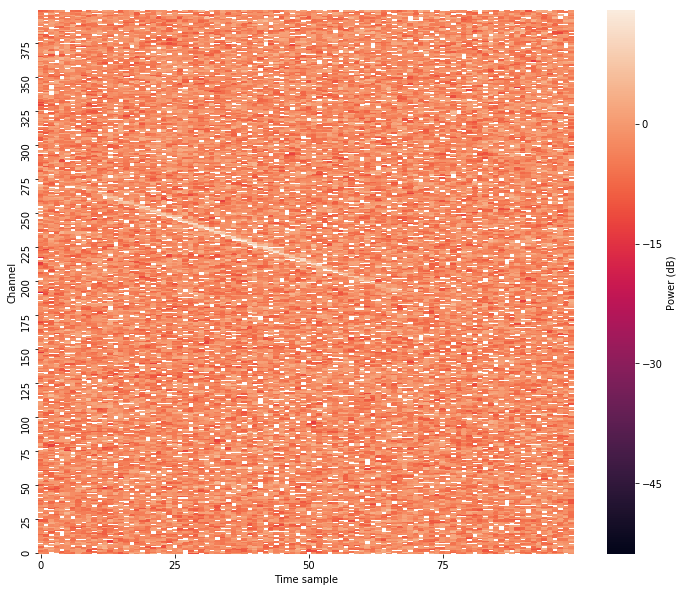

In [232]:
"Test an adaptive filter"
block_size = 5
local_thresh = threshold_local(subset_data, block_size, offset=2)
local_filter_mask = np.where(subset_data < local_thresh, subset_data, 0)
visualise_filter(subset_data, local_filter_mask,local_thresh, 'after_local_filter')

13.958569526672363


[Text(87,0.5,'Channel'), Text(0.5,69,'Time sample')]

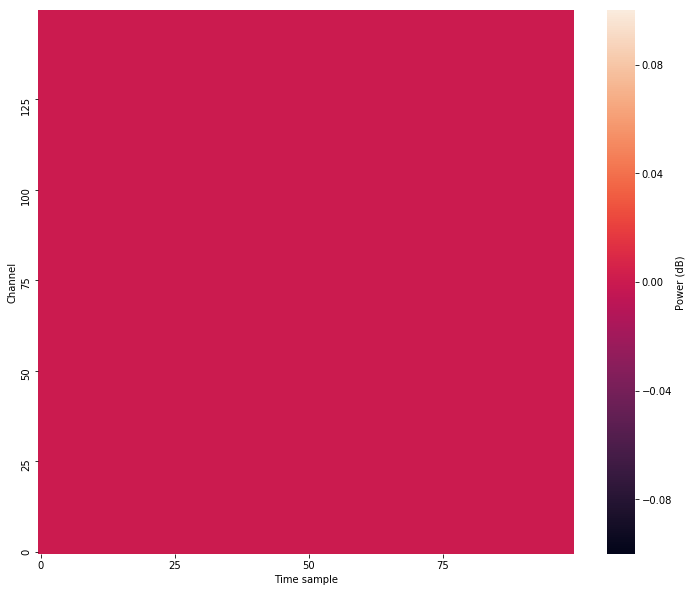

In [281]:
"Test median filter"
from scipy import ndimage
filtered_data = np.array(subset_data, copy=True)  
filtered_data[filtered_data <= np.expand_dims(threshold, axis=1)] = 0

filtered_med = ndimage.median_filter(filtered_data, 20)
# visualise_filter(subset_data, local_filter_mask,local_thresh, 'after_local_filter')
print np.max(filtered_data)
ax = sns.heatmap(filtered_med, cbar_kws={'label': 'Power (dB)'},                   
                  xticklabels=25, 
                  yticklabels=25)
ax.invert_yaxis()
ax.set(xlabel='Time sample', ylabel='Channel')   